In [22]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from pprint import pprint
from sklearn.externals import joblib
%matplotlib inline
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (14, 8)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
#rcParams['grid.color'] = '#eeeeee'
rcParams['grid.color'] = 'white'
rcParams['axes.facecolor'] = '#eeeeee'
#rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 16
rcParams['patch.edgecolor'] = 'none'

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, \
                            classification_report, precision_score, fbeta_score
from sklearn.svm import SVC
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


/Users/dimitriostheoharatos/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Baseline Model

Since this classification problem is highly imbalanced, it makes sense for the baseline model to simply predict the majority-class label for each prediction.  Let's see what these results give us when we always predict that a student will not get certified. 

In [4]:
data = pd.read_csv('data/modeling_data.csv', index_col=0)
data.drop(columns=['course'], inplace = True)

In [5]:
#combine explored and certified into one column since we are counting this as our target variable
data.drop(columns=['explored', 'certified'], inplace = True)

In [6]:
y = data['explored/cert']
X = data.drop(columns=['explored/cert'])
X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size = 0.2, stratify = y)

In [7]:
def baseline_model(y_test):
    #predict the majority-class
    preds = np.tile(0 , (len(y_test),))
    acc = accuracy_score(preds, y_test)

    return acc

    

In [8]:
print(round(baseline_model(y_test),5))

0.8939


## Machine Learning Models

### Logistic Regression

In [9]:
data.head()

,explored/cert,>=70,60s,50s,40s,30s,25_to_30,20_to_25,under_20,MIT,...,month_started_03,month_started_04,month_started_05,month_started_06,month_started_07,month_started_08,month_started_09,month_started_10,month_started_12,gender_f
0,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)
y_pred = log_model.predict(X_test)
y_score=log_model.predict_proba(X_test)[:,1]



In [11]:
print(round(accuracy_score(y_pred, y_test), 5))

0.8939


It looks like using a basic logistic regression without any parameter optimizations is the same as the baseline model.  This means that it is always predicting the majority class, suggesting that the probability of any individual of passing a course is less than 50%. 

Let's dive deeper into the ROC curve to understand what is going on here. 

In [12]:
def plot_roc(name, clf, y_test, X_test):
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (area = %0.3f)' % (name, roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
   #plt.savefig('Log_ROC')
    plt.show()
    return fpr, tpr, thresholds

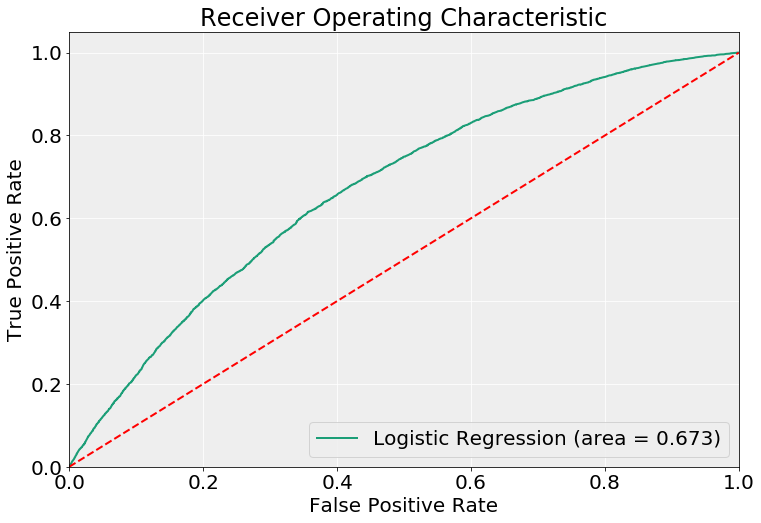

In [13]:
rcParams['figure.figsize'] = (12, 8)
rcParams['font.size'] = 20
log_fpr, log_tpr, log_thresholds = plot_roc("Logistic Regression", log_model, y_test, X_test)


In [14]:
print(np.median(log_tpr), np.median(log_fpr), np.median(log_thresholds))
log_thresholds[0:5], log_thresholds[-6:-1]

0.6936371453138435 0.43715428734717204 0.10176644583993799


(array([1.413771  , 0.413771  , 0.407114  , 0.40046415, 0.39959958]),
 array([0.01095774, 0.01040373, 0.01035098, 0.01022569, 0.01010956]))

The AUC does not look awful, but looking closer into the thresholds for our logistic regression model, it seems that we are only defined for thresholds from 0.01 - 0.43.  The classification report below enforces this notion. The massive class imbalance is clearly taking an effect.  Let's run another model, this time balancing our classes. 

In [15]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       1.00      0.89      0.94     54808
          1       0.00      0.00      0.00         0

avg / total       1.00      0.89      0.94     54808



In [16]:
#balanced logistic regression testing classification report
log_balanced_model = LogisticRegression(class_weight = 'balanced')
log_balanced_model.fit(X_train, y_train)
y_pred = log_balanced_model.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.60      0.94      0.73     31185
          1       0.66      0.16      0.26     23623

avg / total       0.63      0.60      0.53     54808



This seems much more reasonable, though the signal does not seem to be signficant.  Let's look into the training classification report to see if there is any overfitting going on. 

In [17]:
#balanced logistic regression training classification report
y_pred = log_balanced_model.predict(X_train)
print(classification_report(y_pred, y_train))

             precision    recall  f1-score   support

          0       0.60      0.94      0.73    124685
          1       0.66      0.16      0.26     94547

avg / total       0.62      0.60      0.53    219232



The performance on each set are essentially equivalent, suggesting that we are not overfitting.  Before I move on to more sophisticated modeling techniques, I am going to manually shift the threshold to see if we can get a higher recall and how negatively impacts precision. 

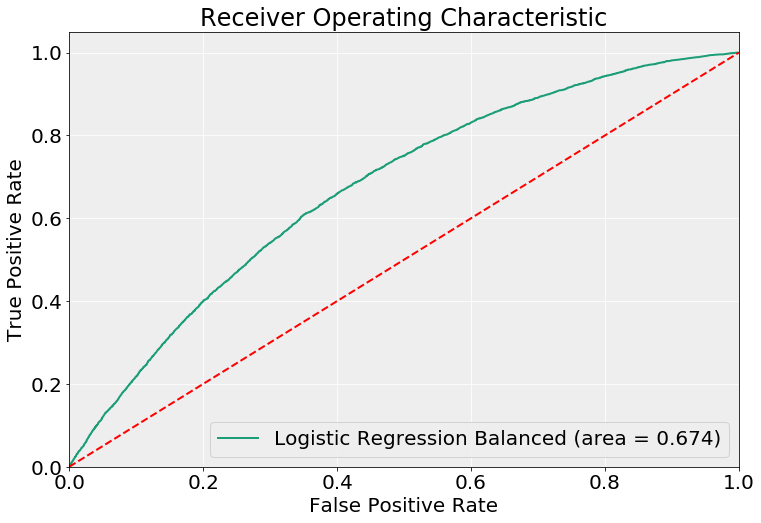

In [18]:
rcParams['figure.figsize'] = (12, 8)

log_balanced_fpr, log_balanced_tpr, log_balanced_thresholds = \
                plot_roc("Logistic Regression Balanced", log_balanced_model, y_test, X_test)


Let's modify the threshold manually to see if we can increase our recall while not impacting the f1-score. 

In [19]:
log_balance_probs = log_balanced_model.predict_proba(X_test)

In [20]:
modified_threshold_pred = np.where(log_balance_probs > 0.58, 1, 0).T[1].T

In [21]:
print(classification_report(modified_threshold_pred, y_test))

             precision    recall  f1-score   support

          0       0.78      0.92      0.84     41462
          1       0.43      0.19      0.26     13346

avg / total       0.69      0.74      0.70     54808



It looks like modifying the threshold to 0.58 enables a bit more recall, which is what I would prefer in this case, while maintaining the respective f1-score for the positive class.  

Let's make sure that our basic logistic regression model is optimized using GridSearchCV.

In [ ]:
#optimize our Logistic Regression model
penalty = ['l1', 'l2']
C = np.logspace(0,4,10)
hyper_params = dict(C = C, penalty = penalty)

In [21]:
clf = GridSearchCV(log_balanced_model, hyper_params, cv = 5, verbose = 0, scoring='roc_auc')
best_model = clf.fit(X,y)
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])


Best Penalty: l2
Best C: 1


In [28]:
joblib.dump(log_balanced_model, "models/log_model.sav")

['models/log_model.sav']

Running the above GridSearch suggests that the optimal parameters are the default parameters.

### Naive Bayes

In [29]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)


In [30]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       1.00      0.89      0.94     54808
          1       0.00      0.00      0.00         0

avg / total       1.00      0.89      0.94     54808



Unsurprisingly, Naive Bayes also always predicts the negative class.  Let's build more sophisticated models to see if we can glean some more insight. 

In [32]:
joblib.dump(nb, "models/nb_model.sav")

['models/nb_model.sav']

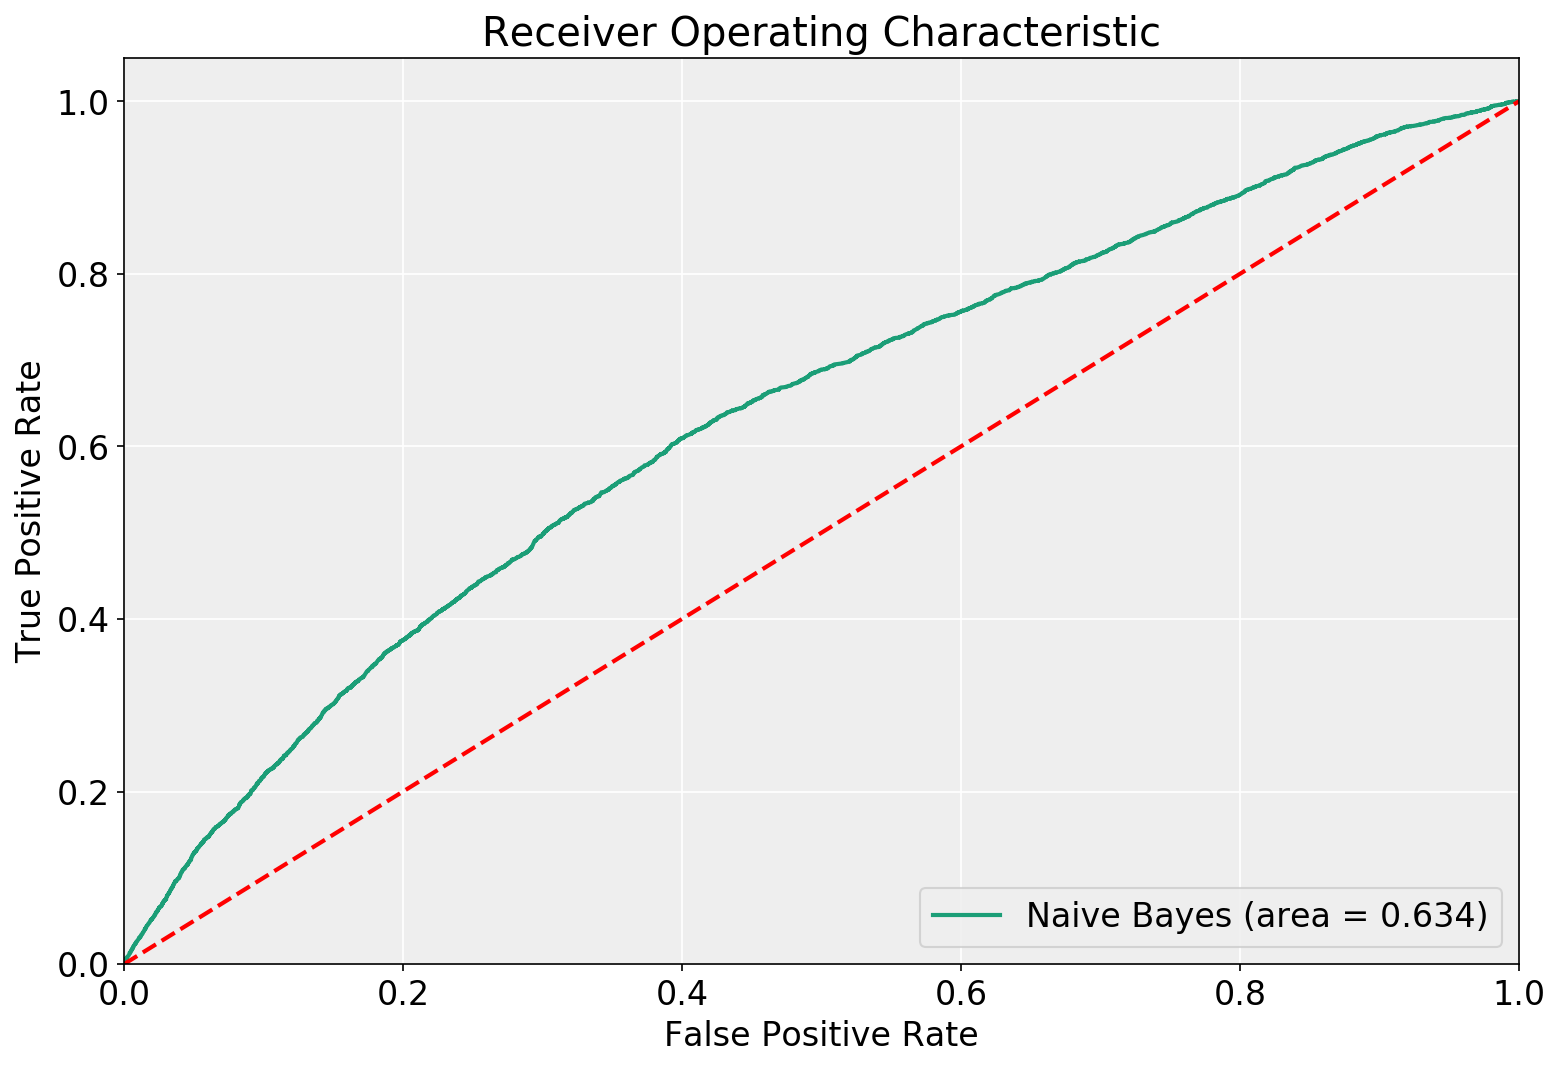

In [31]:
rcParams['figure.figsize'] = (12, 8)

nb_fpr, nb_tpr, nb_thresholds = \
                plot_roc("Naive Bayes", nb, y_test, X_test)

### Random Forest

In [33]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
pprint(rf_model.get_params())


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


We can take a look at the default parameters for our Random Forest Classifier.  We can optimize these parameters using cross-validation to further improve on the mode. 

In [34]:
# Random forest train
y_pred = rf_model.predict(X_train)
print(classification_report(y_pred, y_train))

             precision    recall  f1-score   support

          0       0.99      0.90      0.95    215673
          1       0.10      0.67      0.18      3559

avg / total       0.98      0.90      0.93    219232



In [27]:
# Random forest test
y_pred = rf_model.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.98      0.90      0.94     53872
          1       0.03      0.20      0.06       936

avg / total       0.97      0.88      0.92     54808



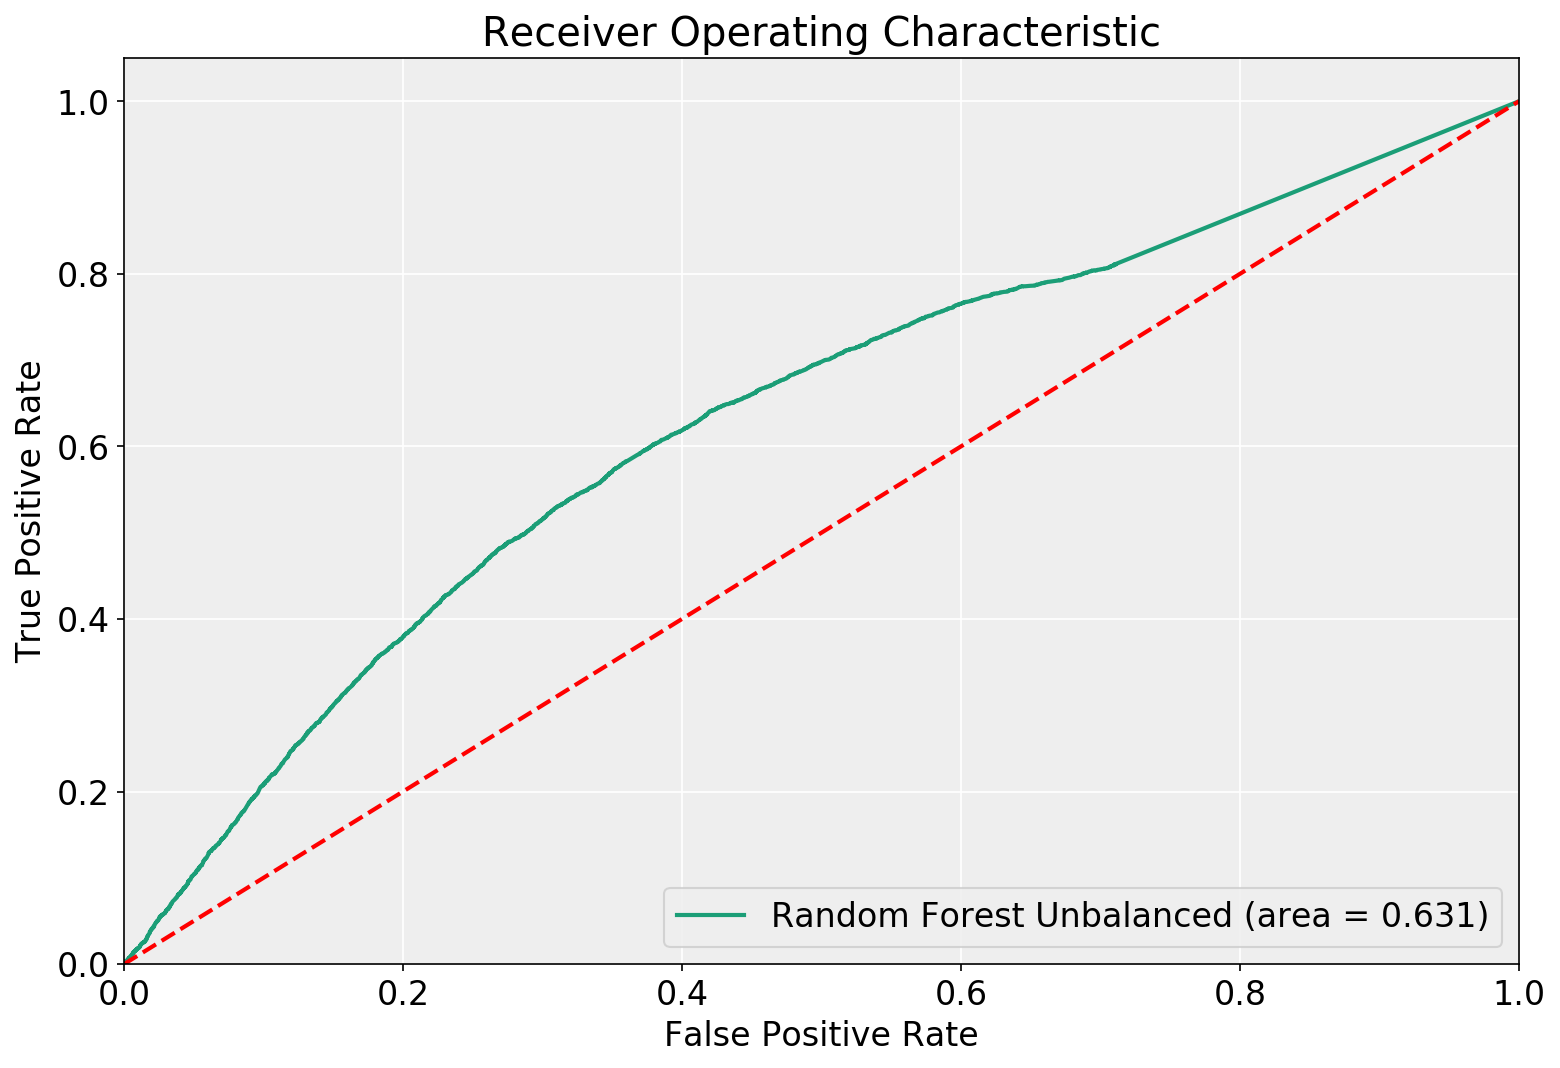

In [35]:
rcParams['figure.figsize'] = (12, 8)
rf_fpr, rf_tpr, rf_thresholds = \
                plot_roc("Random Forest Unbalanced", rf_model, y_test, X_test)

It looks like our default Random Forest is doing worse than our balanced class logistic regression model from an AUC perspective.  Let's set the class weight to balanced to see the impact. 

In [36]:
rf_model_balanced = RandomForestClassifier(class_weight='balanced')
rf_model_balanced.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [37]:
# Random forest test
y_pred = rf_model_balanced.predict(X_test)
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.73      0.92      0.82     39026
          1       0.47      0.17      0.25     15782

avg / total       0.66      0.71      0.65     54808



In [38]:
def plot_mult_roc(names, clfs, y_test, X_test):
    plt.figure(0).clf()
    for name, clf in zip(names, clfs):
        fprs = []
        tprs = []
        fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
        fprs.append(fpr)
        tprs.append(tpr)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='%s (AUC = %0.3f)' % (name, roc_auc))
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
   #plt.savefig('Log_ROC')
    plt.show()
    
    #return fpr, tpr, thresholds

Based on the plot below, it looks like the logistic regression model is outperforming the random forest model without its parameters being tuned. 

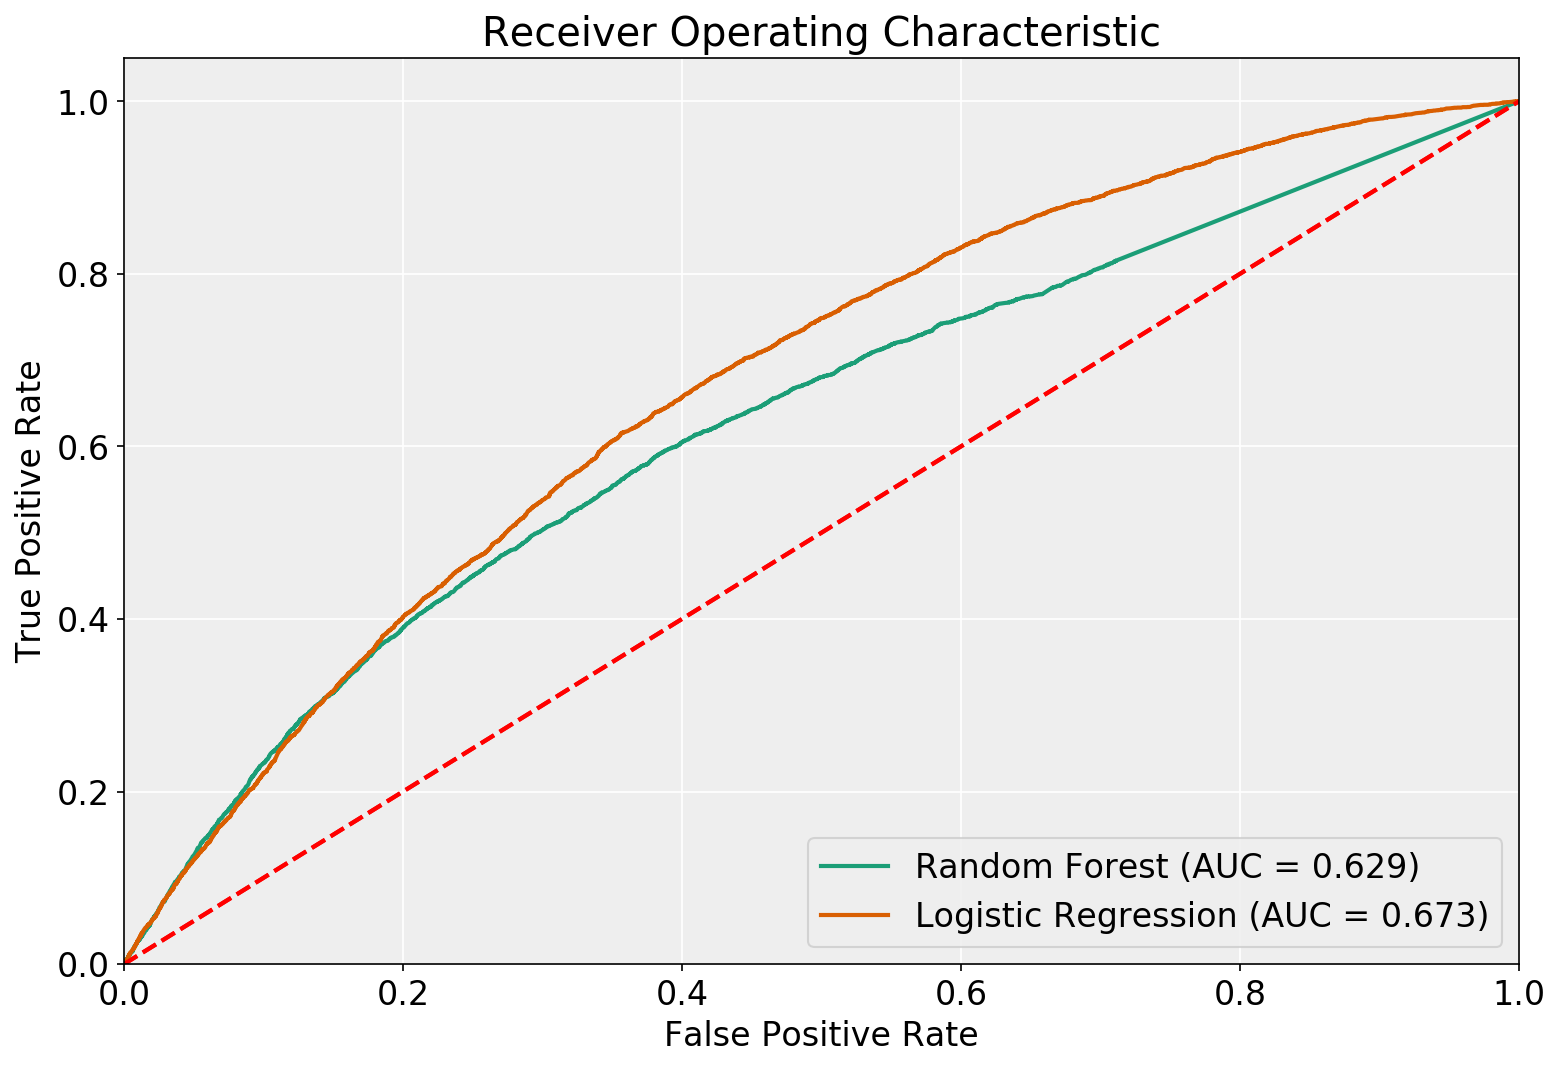

In [39]:
plot_mult_roc(['Random Forest', 'Logistic Regression'], [rf_model_balanced, log_model], y_test, X_test)

We can also try SVM with its default parameters to see what our confusion matrix is looking like. L

### Support Vector Machine

In [ ]:
svm = SVC(class_weight='balanced', probability = True)
svm.fit(X_train, y_train)

#y_score=log.predict_proba(X_test)[:,1]

In [ ]:
y_pred = svm.predict(X_test)

In [83]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.62      0.94      0.75     24453
          1       0.65      0.17      0.27     16653

avg / total       0.64      0.63      0.56     41106



We saw a marginal increase in recall and F1 score for the positive class, but it was a minor increase.  Since it took very look to run, I will attempt to optimize Random Forest over SVM since it took a lot less long to train. 

## Optimizing Random Forest Hyperparameters

Currently, our performance is not great.  We can try and do some fine-tuning to extract some more signal from the noise. Let's look at our original parameters to see which parameters to tune. 

In [40]:
pprint(rf_model.get_params())

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


There are quite a lot of parameters to be tuning but let's hone in on a few to reduce training time. Let's tune the following:

* n_estimators
* max_features
* max_depth
* min_samples_split
* min_samples_leaf
* bootstrap


Let's use RandomizedSearchCV on the above hyperparameters to optimize our random forest.  We'll start with Randomized to find the best ranges for each respective parameter, then use GridSearchCV once we have a simpler range to iterate over for our hyperparameter space. 

In [140]:
n_estimators = list(map(lambda x: int(x), np.linspace(30,100,8)))
min_samples_leaf = [1,2,4]
max_depth = [20,40,60,80,100]
min_samples_split = [2,5,10]

In [141]:
random_grid = {'n_estimators': n_estimators,
                'min_samples_leaf':min_samples_leaf ,
               'max_depth':max_depth ,
                'min_samples_split':min_samples_split
              }

In [148]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs = 4)


In [151]:
rf_cv = RandomizedSearchCV(estimator = rf, param_distributions= random_grid\
                          , n_iter = 100, cv = 3, verbose = 2, scoring='roc_auc', n_jobs=4)

In [152]:
rf_cv.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=2, max_depth=60 
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=2, max_depth=60 
[CV] n_estimators=90, min_samples_split=10, min_samples_leaf=2, max_depth=60 
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=80, total=  16.2s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=80, total=  14.6s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=80 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=2, max_depth=60, total=  33.4s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=4, max_depth=60 
[CV]  n_estimators=90, min_samples_split=10, min_samples_leaf=2, max_depth=60, total=  33.6s
[CV] n_estimators=50

[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.2min


[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=40, total=  38.6s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=40, total=  38.4s
[CV] n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_depth=80, total=  31.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_depth=40, total=  38.8s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_depth=80, total=  29.7s
[CV] n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=70, min_samples_split=10, min_samples_leaf=2, max_depth=80, total=  29.3s
[CV] n_estimators=60, min_samples_split=2, min_sampl

[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=2, max_depth=40, total=  31.6s
[CV] n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_depth=100 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=2, max_depth=40, total=  32.5s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_depth=100, total=  11.5s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=80, min_samples_split=10, min_samples_leaf=2, max_depth=40, total=  31.4s
[CV] n_estimators=90, min_samples_split=2, min_samples_leaf=1, max_depth=100 
[CV]  n_estimators=30, min_samples_split=2, min_samples_leaf=4, max_depth=100, total=  11.5s
[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=2, max_depth=100 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=2, max

[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=60, total=  29.5s
[CV] n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=60, total=  28.2s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=60 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=60, total=  27.8s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=60 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=20, total=  11.3s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=60 
[CV]  n_estimators=40, min_samples_split=10, min_samples_leaf=4, max_depth=20, total=  11.6s
[CV] n_estimators=60, min_samples_split=10, min_samples_leaf=2, max_depth=20 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=2, max_depth=20, total=  22.2s
[CV] n_estimators=60, min_samples_split=10, min_samples_le

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 18.6min


[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=80, total=  28.5s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=80 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=80, total=  27.5s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=2, max_depth=80, total=  27.7s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=80, total=  20.3s
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=2, max_depth=80, total=  20.6s
[CV] n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=20 
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=80 
[CV]  n_estimators=70, min_samples_split=5, min_samples_leaf=4, max_depth=20, total=  20.9s
[CV] n_estimators=50, min_samples_split=2, min_samples_leaf=1, 

[CV] n_estimators=40, min_samples_split=5, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=40, total=  22.2s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=50, min_samples_split=2, min_samples_leaf=1, max_depth=40, total=  21.3s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=4, max_depth=20, total=  11.4s
[CV] n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_depth=20 
[CV]  n_estimators=40, min_samples_split=5, min_samples_leaf=4, max_depth=20, total=  11.4s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=2, max_depth=60 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_depth=20, total=   9.1s
[CV] n_estimators=70, min_samples_split=2, min_samples_leaf=2, max_depth=60 
[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=4, max_depth

[CV]  n_estimators=30, min_samples_split=10, min_samples_leaf=2, max_depth=80, total=  14.1s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=40 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=1, max_depth=60, total=  30.6s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=40 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=1, max_depth=60, total=  29.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=40 
[CV]  n_estimators=60, min_samples_split=10, min_samples_leaf=1, max_depth=60, total=  29.2s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=40, total=  43.8s
[CV] n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=20 
[CV]  n_estimators=50, min_samples_split=5, min_samples_leaf=1, max_depth=20, total=  17.0s
[CV] n_estimators=50, min_samples_split=5, min_samples_

[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed: 35.3min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=4,
          param_distributions={'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100], 'min_samples_leaf': [1, 2, 4], 'max_depth': [20, 40, 60, 80, 100], 'min_samples_split': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='roc_auc', verbose=2)

In [154]:
rf_cv.best_estimator_

<bound method ClassifierMixin.score of RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

In [41]:
best_randomized_rf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [42]:
best_randomized_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=20, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=80, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [38]:
y_pred = best_randomized_rf.predict(X_test)


In [39]:
print(classification_report(y_pred, y_test))

             precision    recall  f1-score   support

          0       0.74      0.93      0.82     39065
          1       0.52      0.19      0.28     15743

avg / total       0.68      0.72      0.67     54808



In [43]:
joblib.dump(best_randomized_rf, "models/rf_model.sav")

['models/rf_model.sav']

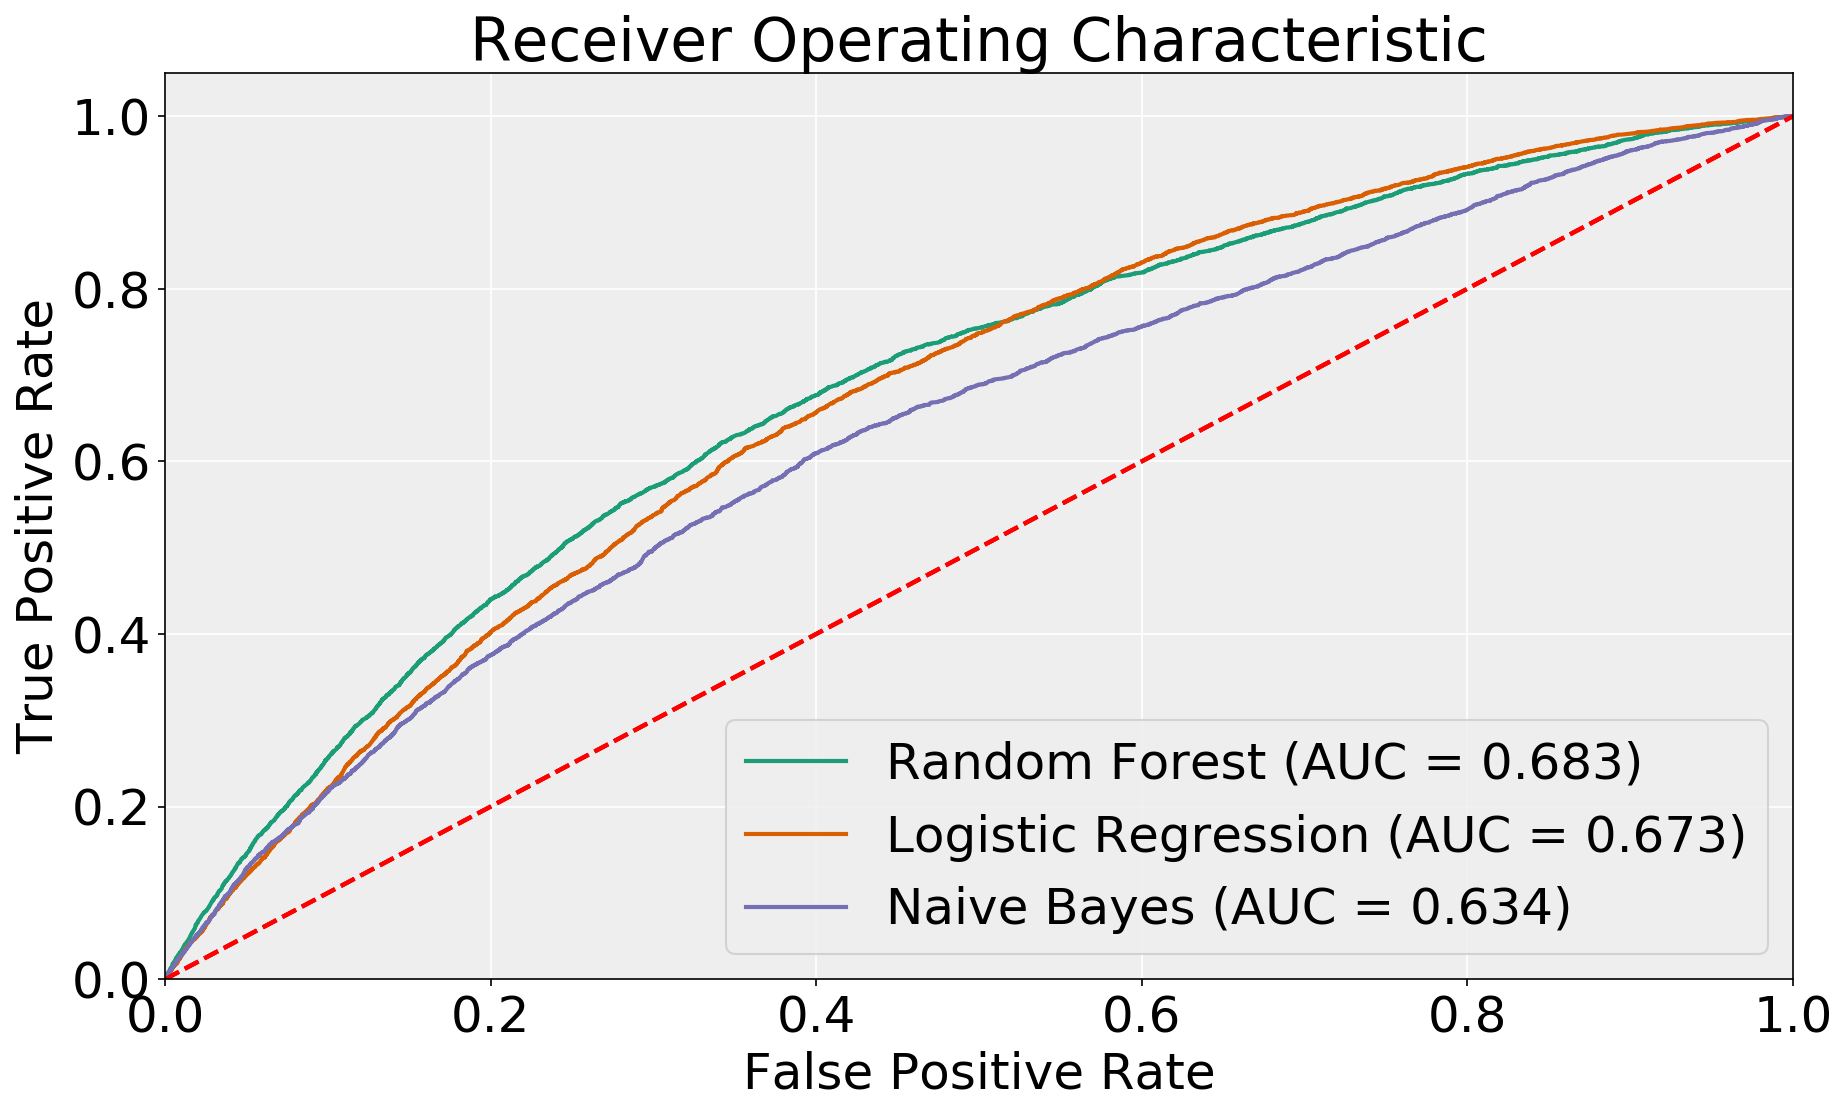

In [44]:
rcParams['figure.figsize'] = (14, 8)

rcParams['font.size'] = 24
plot_mult_roc(['Random Forest', 'Logistic Regression', 'Naive Bayes'], \
              [best_randomized_rf, log_model, nb], y_test, X_test)

In [40]:
rcParams['figure.figsize'] = (14, 8)

rcParams['font.size'] = 24
plot_mult_roc(['Random Forest', 'Logistic Regression', 'Naive Bayes', 'Support Vector Machine'], \
              [best_randomized_rf, log_model, nb, svm], y_test, X_test)

NameError: name 'svm' is not defined